In [ ]:
!pip install -r '/content/drive/MyDrive/Colab Notebooks/Stepik/NLP/requirements.txt'

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
!pip install scikit-learn

In [42]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [5]:
RND_STATE = 73

In [6]:
df = pd.read_csv('df_preprocessed.csv')

In [7]:
df.head(3)

,Unnamed: 0,url,title,topic,datetime,content,subtitle
0,0,https://lenta.ru/news/2020/01/01/trudovaya/,В России ввели электронные трудовые книжки,Россия,2020-01-01 00:01:00,Фото: Юрий Мартьянов /« Коммерсантъ» В России...,Фото: Юрий Мартьянов /« Коммерсантъ» В ... кн...
1,2,https://lenta.ru/news/2020/01/01/org/,В России утвердили стандарты органической еды,Экономика,2020-01-01 00:30:49,Фото: Rupert Oberhäuser / Globallookpress.com ...,Фото: Rupert Oberhäuser / ... для производител...
2,3,https://lenta.ru/news/2020/01/01/sleep/,Объяснена опасность неправильного сна,Наука и техника,2020-01-01 00:53:00,Фото: Vladislav Muslakov / Unsplash Спящие бол...,"Фото: Vladislav Muslakov / Unsplash ..., чем т..."


In [8]:
# Удалим ненужный столбец
df.drop(
    columns=["Unnamed: 0"],
    inplace=True,
)

## Предобработка текста

Чтобы получить более точное и компактное представление текстов, обычно делают нормализацию текста, которая включает в себя следующие этапы:

- lowering

- tokenize

- lemmatize

- remove symbols

- remove stop-words

Для нас совершенно не важен регистр текста, его род и падеж, а также различные символы, которые и вовсе текстом не являются.

Таким образом, мы ожидаем, что после предобработки текста качество модели должно возрасти.

Существуют разные библиотеки для обработки текста, мы будем использовать Наташу, потому что она включяет в себя все необходимые нам элементы предобработки (токенизация и лемматизация)


In [11]:
# Стоп-слова
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "комментарий",
        "английский",
        "язык",
    ]
)

In [12]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

Напишем функцию, которая будет осуществлять всю указанную выше предобработку текста.

In [13]:
def text_prep(text) -> str:
    # Преобразуем текст в объект класса документ
    doc = Doc(text)
    # Сегментация
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    # Токенизация
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    # Лемматизация
    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [14]:
%%time
df["title_clean"] = df['title'].apply(text_prep)
df["subtitle_clean"] = df['subtitle'].apply(text_prep)
df["content _clean"] = df['content'].apply(text_prep)

CPU times: user 20min 37s, sys: 10min 55s, total: 31min 33s
Wall time: 18min 25s


In [15]:
# Сохранение датасета с обработанным текстом
df.to_pickle("df_topics_clean.p", compression="gzip")

In [17]:
df = pd.read_pickle("/content/df_topics_clean.p", compression="gzip")

In [22]:
df.head(3)

,url,title,topic,datetime,content,subtitle,title_clean,subtitle_clean,content\t_clean
0,https://lenta.ru/news/2020/01/01/trudovaya/,В России ввели электронные трудовые книжки,Россия,2020-01-01 00:01:00,Фото: Юрий Мартьянов /« Коммерсантъ» В России...,Фото: Юрий Мартьянов /« Коммерсантъ» В ... кн...,россия ввести электронный трудовой книжка,фото юрий мартьян коммерсантъ книжка вместо бу...,фото юрий мартьян коммерсантъ россия работник ...
1,https://lenta.ru/news/2020/01/01/org/,В России утвердили стандарты органической еды,Экономика,2020-01-01 00:30:49,Фото: Rupert Oberhäuser / Globallookpress.com ...,Фото: Rupert Oberhäuser / ... для производител...,россия утвердить стандарт органический еда,фото rupert oberhäuser производитель продавец ...,фото rupert oberhäuser globallookpress com рос...
2,https://lenta.ru/news/2020/01/01/sleep/,Объяснена опасность неправильного сна,Наука и техника,2020-01-01 00:53:00,Фото: Vladislav Muslakov / Unsplash Спящие бол...,"Фото: Vladislav Muslakov / Unsplash ..., чем т...",объяснить опасность неправильный сон,фото vladislav muslakov unsplash спать примерн...,фото vladislav muslakov unsplash спать менее ч...


Посмотрим, насколько разумно работает наша предобработка, оценив качество преобразования текстовых данных.

In [18]:
# Заголовок
df.sample(1)[['title', 'title_clean']].values

array([['Помочившегося на портрет ветерана блогера посадили на четыре года',
        'помочиться портрет ветеран блогер посадить четыре год']],
      dtype=object)

In [19]:
# Подзаголовок
df.sample(1)[['subtitle', 'subtitle_clean']].values

array([['Александр Куренков Фото: Пресс-служба ... стал генерал-майор Александр Куренков. Об этом сообщается на сайте Кремля. На данном посту Александр Куренков ... года во время учений в Норильске.',
        'александр куренков фото стать александр куренков сообщаться сайт кремль данный пост александр куренков год время учение норильск']],
      dtype=object)

In [23]:
# Содержание
df.sample(1)[['content', 'content\t_clean']].values

array([['Фото: Philip Davali / Ritzau Scanpix / Reuters Дмитрий Настасьев Россия и Украина имеют высокие шансы урегулировать нынешнее обострение между странами миром. С таким заявлением выступил глава МИД Украины Дмитрий Кулеба на очередном брифинге украинского внешнеполитического ведомства, передает «РБК-Украина». «Если Россия прибегнет к вооруженной эскалации, то мы будем защищаться и бороться. Но сейчас есть все шансы на то, что дипломатия сможет достичь успеха», — рассказал Кулеба. Конфликт между Москвой и Киевом можно решить миром, уверен он. На фоне слухов о якобы намечающемся в феврале 2022 года российском вторжении украинцы начали массово скупать из магазинов продукты, в том числе гречку и сахар. Многие граждане республики действительно верят в скорую военную агрессию со стороны России и провоцируют подобное поведение. Успокаивать украинцев пришлось президенту страны Владимиру Зеленскому, который призвал людей не поддаваться панике. Сообщения о «планах России» по вторжению на У

## Word2Vec

Давайте теперь применим альтернативный подход к представлению слов - Word2Vec. Этот метод основывается на семантической близости слов. Построим модель на нашей выборке новостей.

In [25]:
model = Word2Vec(sentences=df['title_clean'].str.split(),
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

Посмотрим, насколько разумные у нас получились вектора.



In [26]:
model.wv.most_similar(positive=["вакцина"])

[('вакцинация', 0.9936399459838867),
 ('штамм', 0.9931243062019348),
 ('борьба', 0.9925747513771057),
 ('лекарство', 0.9893422722816467),
 ('грипп', 0.9885976910591125),
 ('сутки', 0.9884377717971802),
 ('пандемия', 0.9875685572624207),
 ('мутация', 0.9875579476356506),
 ('ограничение', 0.9875509142875671),
 ('волна', 0.9873950481414795)]

В целом все логично: близкие вектора - это вектора слов, обозначающих болезни и связанные с ними слова.

In [27]:
model.wv.most_similar(positive=["путин"])

[('зеленский', 0.9957272410392761),
 ('кремль', 0.99076247215271),
 ('байден', 0.9856115579605103),
 ('возможность', 0.984728217124939),
 ('лукашенко', 0.9841989278793335),
 ('готовность', 0.9838525056838989),
 ('слово', 0.9832051396369934),
 ('трамп', 0.9824982285499573),
 ('мид', 0.9819431900978088),
 ('вопрос', 0.9818465709686279)]

In [30]:
model.wv.most_similar(positive=["нефть"])

[('газ', 0.9963499903678894),
 ('рост', 0.9828960299491882),
 ('европа', 0.9693187475204468),
 ('бензин', 0.9677265286445618),
 ('потолок', 0.9675039052963257),
 ('поставка', 0.9632241725921631),
 ('вырасти', 0.961024284362793),
 ('снижение', 0.959913969039917),
 ('резко', 0.9589304327964783),
 ('продукт', 0.9585208892822266)]

Видим, что все выглядит очень логично и даже увлекательно :)

Чтобы построить модель, нам нужно получить вектора для предложения. Это можно сделать двумя способами:

- Усреднить вектора слов, входящих в предложение
- Взвесить вектора слов, входящих в предложение на основании их tf-idf весов

Важно заметить, что здесь легко совершить методологическую ошибку. Ранее мы обучали вектора на всей выборке, а теперь для валидации сделаем честный эксперимент и обучим только на тренировочной.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df['content\t_clean'].str.split(),
                                                    df['topic'].values,
                                                    random_state=RND_STATE)

model = Word2Vec(sentences=X_train,
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

Для того, чтобы по-прежнему использовать Pipeline, оформим описанные выше подходы в классы.

### Логистическая регрессия

In [32]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [36]:
# векторизация (усреднение векторов слов)
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=1000))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.76      0.69      0.72       916
              Мир       0.78      0.83      0.81      1318
  Наука и техника       0.86      0.83      0.84       489
           Россия       0.78      0.82      0.80      1778
Силовые структуры       0.85      0.81      0.83       532
            Спорт       0.99      0.96      0.97       551
        Экономика       0.87      0.86      0.87       931

         accuracy                           0.82      6515
        macro avg       0.84      0.83      0.83      6515
     weighted avg       0.82      0.82      0.82      6515



In [35]:
y_pred = pipe.predict(X_test)

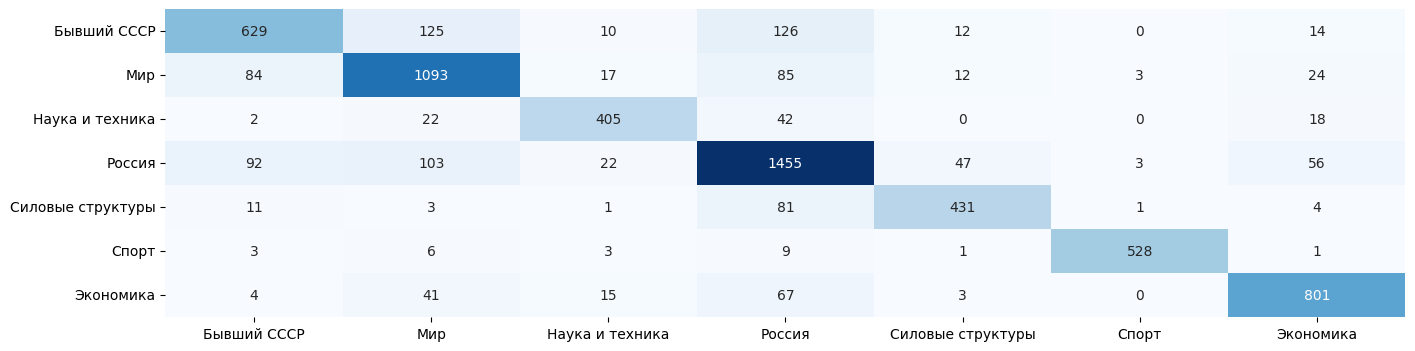

In [38]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

#### Tf-Idf

In [44]:
# Векторное представление слов и преобразование векторов слов с помощью Tf-Idf
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [45]:
pipe_tf_idf = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000))])

pipe_tf_idf.fit(X_train, y_train)

print(classification_report(y_test, pipe_tf_idf.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.78      0.71      0.75       916
              Мир       0.81      0.84      0.82      1318
  Наука и техника       0.87      0.85      0.86       489
           Россия       0.79      0.83      0.81      1778
Силовые структуры       0.87      0.82      0.84       532
            Спорт       0.99      0.97      0.98       551
        Экономика       0.87      0.86      0.87       931

         accuracy                           0.83      6515
        macro avg       0.85      0.84      0.85      6515
     weighted avg       0.83      0.83      0.83      6515



In [46]:
y_pred = pipe_tf_idf.predict(X_test)

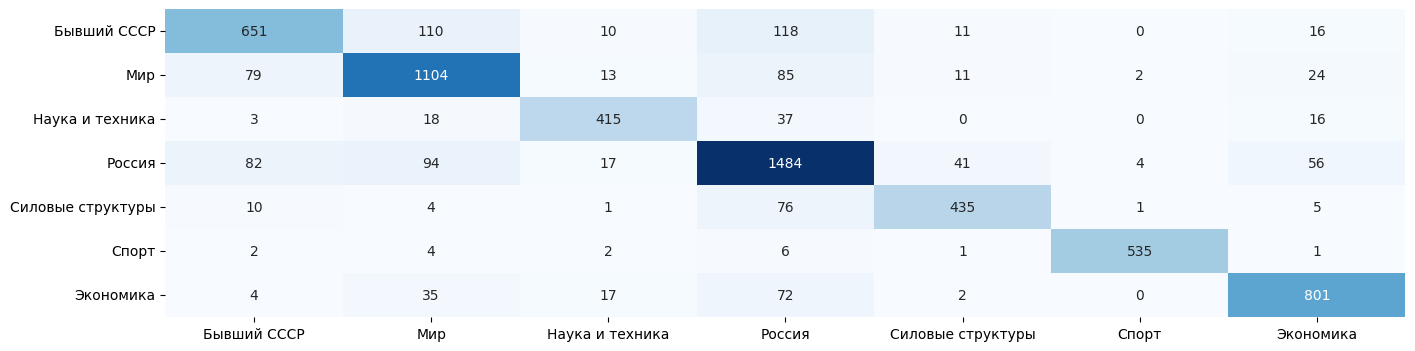

In [48]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipe_tf_idf.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe_tf_idf.classes_, index=pipe_tf_idf.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

### Метод опорных векторов SVM

In [52]:
# SVM + векторизация (усреднение векторов слов)
pipe_SVM_mean = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ("clf", SVC(random_state=RND_STATE, max_iter=10000))])

pipe_SVM_mean.fit(X_train, y_train)

print(classification_report(y_test, pipe_SVM_mean.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.78      0.72      0.75       916
              Мир       0.78      0.85      0.81      1318
  Наука и техника       0.89      0.84      0.87       489
           Россия       0.82      0.82      0.82      1778
Силовые структуры       0.86      0.83      0.84       532
            Спорт       0.99      0.95      0.97       551
        Экономика       0.86      0.88      0.87       931

         accuracy                           0.83      6515
        macro avg       0.85      0.84      0.85      6515
     weighted avg       0.83      0.83      0.83      6515



In [53]:
y_pred = pipe_SVM_mean.predict(X_test)

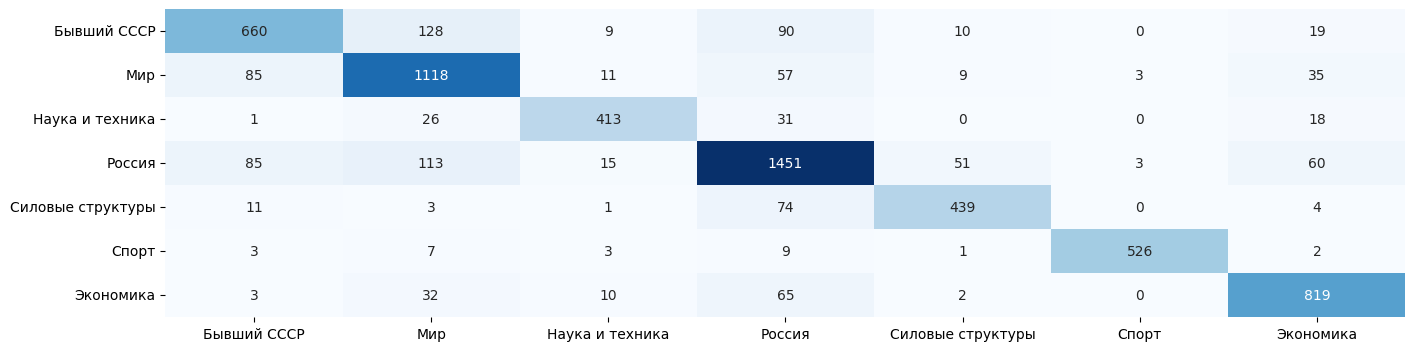

In [54]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipe_SVM_mean.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe_SVM_mean.classes_, index=pipe_SVM_mean.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

In [49]:
# SVM + Векторное представление слов и преобразование векторов слов с помощью Tf-Idf
pipe_SVM_tf_idf = Pipeline([("w2v", TfidfEmbeddingVectorizer(model)),
                     ("clf", SVC(random_state=RND_STATE, max_iter=10000))])

pipe_SVM_tf_idf.fit(X_train, y_train)

print(classification_report(y_test, pipe_SVM_tf_idf.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.77      0.72      0.75       916
              Мир       0.79      0.85      0.82      1318
  Наука и техника       0.91      0.85      0.88       489
           Россия       0.82      0.82      0.82      1778
Силовые структуры       0.86      0.82      0.84       532
            Спорт       0.99      0.97      0.98       551
        Экономика       0.86      0.89      0.87       931

         accuracy                           0.84      6515
        macro avg       0.86      0.84      0.85      6515
     weighted avg       0.84      0.84      0.84      6515



In [50]:
y_pred = pipe_SVM_tf_idf.predict(X_test)

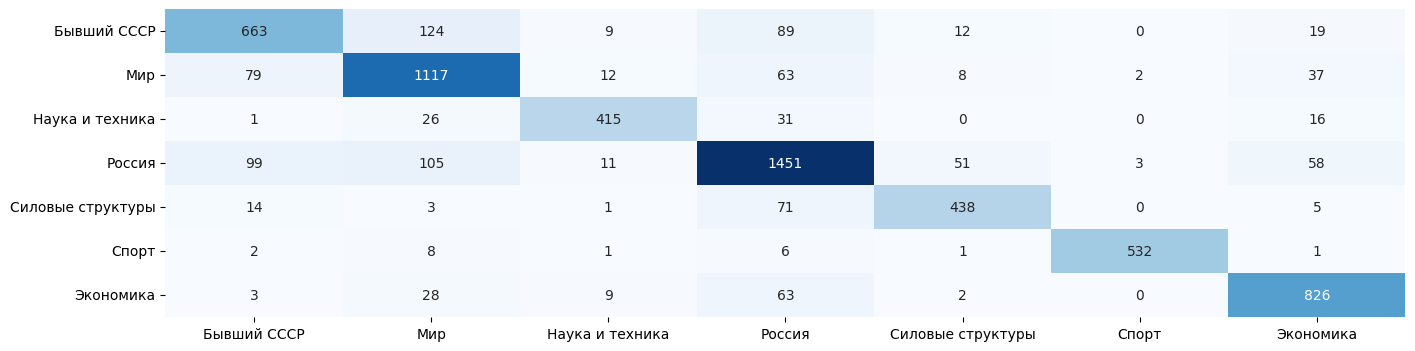

In [51]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipe_SVM_tf_idf.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe_SVM_tf_idf.classes_, index=pipe_SVM_tf_idf.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

### Вывод

Были построены 4 модели:
- логистическая регрессия + усреднить вектора слов, входящих в предложение;

`accuracy 0.82`
- лоничстическая регрессия + взвесить вектора слов, входящих в предложение на основании их tf-idf весов;

`accuracy 0.83`
- метод опорных векторов + усреднить вектора слов, входящих в предложение;

`accuracy 0.84`
- метод опорных векторов + взвесить вектора слов, входящих в предложение на основании их tf-idf весов;

`accuracy 0.83`

Давольно часто путались рубрики Бывший СССР, Мир, Россия, Силовые структуры. Однако эти рубрики очень похожи друг на друга, да и еще был не очень сбалансированный датасет. Особо различий между моделями нет, все хорошо справились.